## add segmentation from Aeroscapes

In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
from PIL import ImageFilter
import ast
import json
from glob import glob

In [2]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [3]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

In [4]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.1', True)

In [5]:
#tf.config.optimizer.set_jit(True)

In [6]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [7]:
class_names = ['bg', 'person', 'bicycle', 'lean', 'car']

padded_image_shape = (1024, 1920)
anchor_k = 6
num_classes = 30
num_classes_real = len(class_names)
max_data_m = 4000#00#0#0
use_MOT = False
use_pedestrian = False
use_visdrone = False
use_Aeroscapes = True
level_start = 4
level_end = 7
l1 = 1e-8 #1e-9
activation = 'swish'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)

In [8]:
num_classes_real

5

In [9]:
path_pedestrian = '/home/mvlab/Downloads/dataset/통영/'
forder_P_DESTRE = '/home/mvlab/Downloads/dataset/P-DESTRE/'
folder_weather = '/home/sogangori/Downloads/dataset/weather/'

names = ['fn','cname','id', 'x0', 'y0', 'w', 'h']
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
path_weight = "weight/pedestrian_efficientSeg-2"

os.path.isdir(path_pedestrian), os.path.isdir(forder_P_DESTRE)

(True, True)

In [10]:
use_weather_effect = os.path.isdir(folder_weather)
use_weather_effect, folder_weather

(False, '/home/sogangori/Downloads/dataset/weather/')

In [11]:
weather_images = []
if use_weather_effect:
    path_weathers = glob(folder_weather + '*.*')
    if len(path_weathers)>0:
        for path_weather in path_weathers:            
            image = Image.open(path_weather) 
            weather_images.append(image)            
            plt.imshow(image)
            plt.show()
    else:
        use_weather_effect = False

### Aeroscapes

In [12]:
class_aeroscapes = [ 'bg', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'construction', 'vegetation', 'road', 'sky']
class_aeroscapes = [ 'unknown', 'background', 'water', 'bg', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'construction', 'vegetation', 'road', 'sky']
seg_k = len(class_aeroscapes)
seg_k, class_aeroscapes

(15,
 ['unknown',
  'background',
  'water',
  'bg',
  'person',
  'bike',
  'car',
  'drone',
  'boat',
  'animal',
  'obstacle',
  'construction',
  'vegetation',
  'road',
  'sky'])

### Sacheon

class_Sacheon = ['unknown', 'bg', 'water']
seg_k = len(class_Sacheon)
seg_k

In [13]:
folder_aeroscapes = '/home/mvlab/Downloads/dataset/aeroscapes/'
folder_aeroscapes_rgb = folder_aeroscapes + 'JPEGImages/'
folder_aeroscapes_seg = folder_aeroscapes + 'SegmentationClass/'

os.path.isdir(folder_aeroscapes), os.path.isdir(folder_aeroscapes_rgb), os.path.isdir(folder_aeroscapes_seg)

(True, True, True)

In [14]:
paths_aeroscapes_rgb = glob(folder_aeroscapes_rgb + '*.jpg')
paths_aeroscapes_seg = glob(folder_aeroscapes_seg + '*.png')

len(paths_aeroscapes_rgb), len(paths_aeroscapes_seg)

(3269, 3269)

In [15]:
folder_Sacheon = '/home/mvlab/Downloads/dataset/20210208_segmentation 사천/'
folder_Sacheon_rgb = folder_Sacheon + 'JPEGImages/'
folder_Sacheon_seg = folder_Sacheon + 'SegmentationClass/'

os.path.isdir(folder_Sacheon), os.path.isdir(folder_Sacheon_rgb), os.path.isdir(folder_Sacheon_seg)

(True, True, True)

In [16]:
folder_Sacheon_rgb = glob(folder_Sacheon_rgb + '*.*')
folder_Sacheon_seg = glob(folder_Sacheon_seg + '*.png')

len(folder_Sacheon_rgb), len(folder_Sacheon_seg)

(89, 89)

In [17]:
len(paths_aeroscapes_rgb), len(folder_Sacheon_rgb)

(3269, 89)

In [18]:
stride = len(paths_aeroscapes_rgb) // len(folder_Sacheon_rgb)
stride

36

In [19]:
type(paths_aeroscapes_rgb), len(paths_aeroscapes_rgb)

(list, 3269)

In [20]:
folder_Sacheon_rgb = list(np.sort(folder_Sacheon_rgb))
folder_Sacheon_seg = list(np.sort(folder_Sacheon_seg))

paths_aeroscapes_rgb = list(np.sort(paths_aeroscapes_rgb))
paths_aeroscapes_seg = list(np.sort(paths_aeroscapes_seg))

In [21]:
folder_seg_rgb = paths_aeroscapes_rgb
folder_seg_seg = paths_aeroscapes_seg

for i in range(len(folder_Sacheon_rgb)):
    folder_seg_rgb.insert(i*stride, folder_Sacheon_rgb[i])
    folder_seg_seg.insert(i*stride, folder_Sacheon_seg[i])

sample_img (1920, 1080)


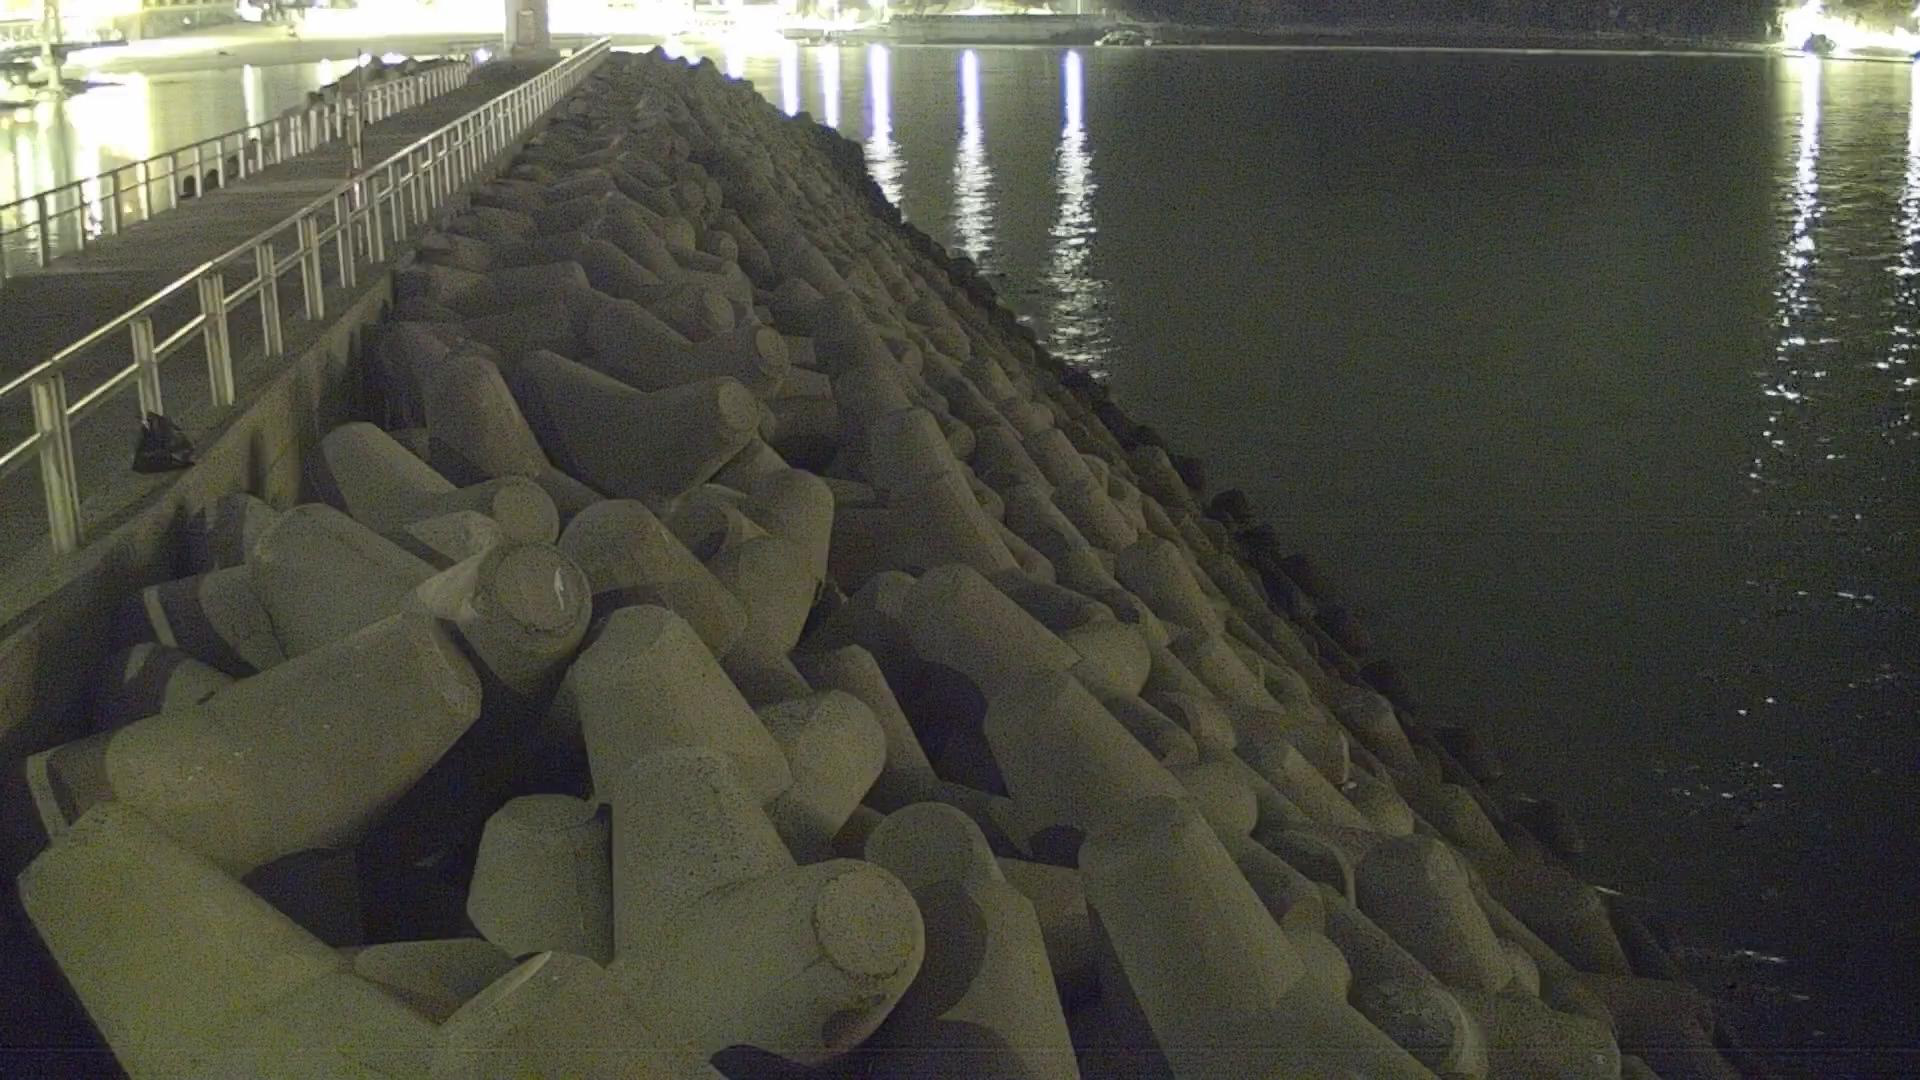

In [22]:
sample_img = Image.open(folder_Sacheon_rgb[0])
print('sample_img', sample_img.size)
sample_img#.resize((200, 100), Image.NEAREST)

In [23]:
sample_img.size, padded_image_shape

((1920, 1080), (1024, 1920))

sample_seg 0 2 [0 1 2]


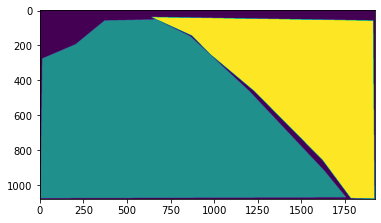

In [24]:
sample_seg = np.array(Image.open(folder_Sacheon_seg[0]))
print('sample_seg', np.min(sample_seg), np.max(sample_seg), np.unique(sample_seg))
plt.imshow(sample_seg)

In [25]:
#파일 이름 같은지 확인
for rgb, seg in zip(folder_seg_rgb, folder_seg_seg):
    rgb_file = rgb.split(os.sep)[-1]
    seg_file = seg.split(os.sep)[-1]
    rgb_file_name = rgb_file.split('.')[0]
    seg_file_name = seg_file.split('.')[0]
    if seg_file_name != seg_file_name:
        print('Error')
        print(rgb_file_name, seg_file_name)

In [26]:
sample_rgbs = np.concatenate((np.array(sample_img), np.expand_dims(np.array(sample_seg), -1)), -1)
sample_rgbs.shape

(1080, 1920, 4)

In [27]:
'사천' in folder_seg_seg[0], 'aeroscapes' in folder_seg_seg[1]

(True, True)

In [30]:
def load_Aeroscapes(folder_rgb, folder_seg, stride=1, max_data_m=max_data_m):
    input_list, segment_list, path_list = [], [], []
       
    print('len images', len(folder_rgb), len(folder_seg))
    
    resize_h, resize_w = padded_image_shape
    for i in range(0, len(folder_rgb), stride):        
        img_rgb = Image.open(folder_rgb[i])
        img_seg = Image.open(folder_seg[i])
        
        img_rgb_resized = img_rgb#.resize((resize_w, resize_h))
        img_seg_resized = img_seg#.resize((resize_w, resize_h), Image.NEAREST)        
                
        seg_arr = np.array(img_seg_resized)
        rgb_arr = np.array(img_rgb_resized)
        
        if rgb_arr.ndim!=3:
            print('rgb_arr.ndim', rgb_arr.ndim)
            continue
        
        if img_rgb_resized.size[:2]!= img_seg_resized.size:
            print('size diff', img_rgb_resized.size, img_rgb.size)
            continue        
        
        if np.max(seg_arr) < 2:
            print('pass, seg_arr', np.unique(seg_arr),folder_rgb[i])
            continue
        elif 'aeroscapes' in folder_rgb[i]:
            seg_arr += 3 #Sacheon 3 classes
        
        input_list.append(rgb_arr)
        segment_list.append(seg_arr)
        path_list.append(paths_aeroscapes_rgb)
        
        if len(input_list) % 500==0:
            print('len', len(input_list), len(segment_list), len(path_list))
        if len(input_list) >= max_data_m:
            break
    
    print('len', len(input_list), len(segment_list), len(path_list))
    return input_list, segment_list, path_list


In [31]:
if use_Aeroscapes:
    input_list_aero, segment_list_aero, path_list_aero = load_Aeroscapes(folder_seg_rgb, folder_seg_seg, stride=1, max_data_m=max_data_m)
    print(len(input_list_aero))

len images 3358 3358
len 500 500 500
len 1000 1000 1000
len 1500 1500 1500
len 2000 2000 2000
len 2500 2500 2500
len 3000 3000 3000
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310005_004.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310005_008.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310005_012.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310005_016.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310005_020.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310005_024.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310015_020.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310015_024.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310015_036.jpg
pass, seg_arr [0 1] /home/mvlab/Downloads/dataset/aeroscapes/JPEGImages/310016_004.jp

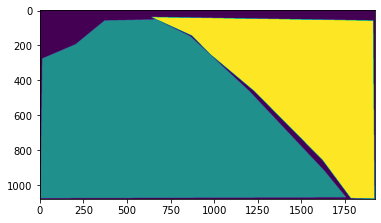

In [33]:
if use_Aeroscapes:
    plt.imshow(segment_list_aero[0])

In [34]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [35]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h = image.shape[0]
    img_w = image.shape[1]
    
    if image.ndim > 2:
        image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    box_min_height = np.min(boxes_height)
    box_max_height = np.max(boxes_height)
    title = str.format('(%dx%d) %d box, width:%d ~ %d, height:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width, box_min_height, box_max_height))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        
        color = edgecolors[min(len(edgecolors)-1,int(cls))]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 170:
            #score_txt = class_names[int(cls)]
            score_txt = str(int(cls))
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]            
            bbox = sample_box[:, :4]
            label = sample_box[:, 4]
            
            if img_arr.ndim < 2:
                print('img_arr.ndim < 2')
                continue
            
            h = img_arr.shape[0]
            w = img_arr.shape[1]
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [36]:
def load_xy(annotation, rescale=1, stride=1, size_cut=False):
    input_list = []
    bbox_list = []
    path_list = []
    i = 0
    #np.random.rand() #미리 만들어놔
    for path_image in annotation:
        i+=1
        if stride!=1 and np.random.randint(1, 1+stride)%stride!=0:
            continue
            
        cls_bbox = annotation[path_image]                
        bbox = np.array(cls_bbox[:, :4])
        attribute = cls_bbox[:, 4:]

        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))

        if rescale!=1:
            img = img.resize((img.width//rescale, img.height//rescale))

        img_arr = np.array(img)
        try:
            std_v = np.std(img_arr)
            if std_v < 3:
                print('std_v', std_v)
                continue
        except:
            print('error', path_image)
            continue
        
        box_width = bbox[:, 3] - bbox[:, 1]
        box_height = bbox[:, 3] - bbox[:, 1]
        
        if np.min(box_width) < 1 or np.min(box_height) < 1:
            print('box_size < 1', box_width, box_height)#check
            continue
            
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((bbox_norm, attribute), axis=1)

        if size_cut:                
            box_height = cls_bbox_norm[:, 3] - cls_bbox_norm[:, 1]
            box_height_max = np.max(box_height)
            if box_height_max < 0.05 or box_height_max > 0.2:
                continue

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(path_image)
        if len(input_list)%100==0:        
            print(len(annotation), i, len(input_list))   
        if len(input_list) > max_data_m:
            break       

    print(len(input_list), len(bbox_list))
    return input_list, bbox_list

display_data(input_list, bbox_list, stride=100)

In [37]:
m = len(input_list_aero)
print('m', m)
s = 1
input_list_train = input_list_aero
input_list_test = input_list_aero[1::2]
seg_list_train = segment_list_aero
seg_list_test = segment_list_aero[1::2]

m 3313


In [38]:
len(input_list_train), len(seg_list_train), len(input_list_test), len(seg_list_test)

(3313, 3313, 1656, 1656)

0 [0 1]


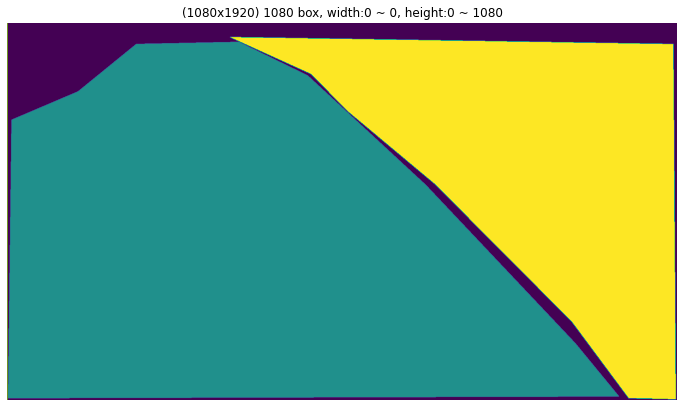

1000 [ 3 10 14]


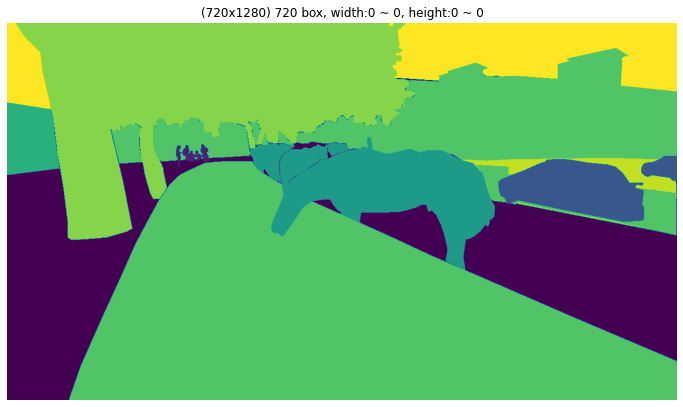

2000 [ 3 12 13]


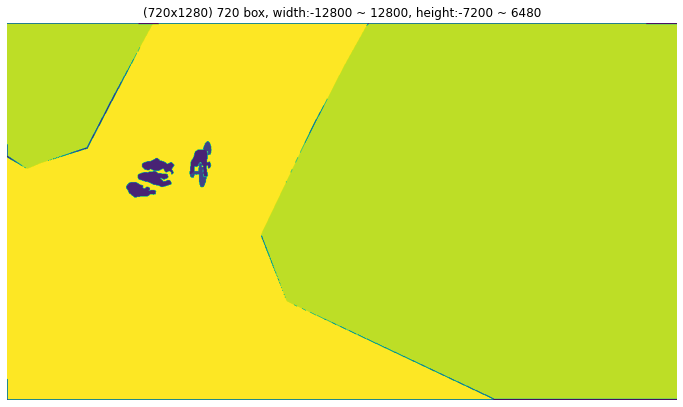

3000 [ 3 11 12 14]


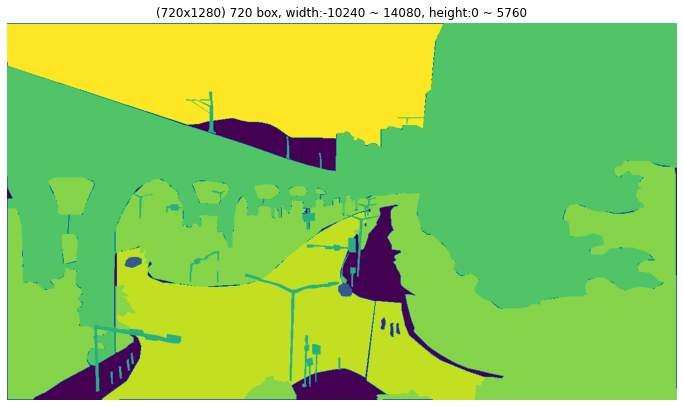

In [39]:
display_data(segment_list_aero, segment_list_aero, stride=1000)

In [40]:
padded_image_shape, 128*8

((1024, 1920), 1024)

In [41]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
   
    return image, boxes


def resize_and_pad_image(
    image, min_side=1024.0, max_side=11333.0, jitter=[128*8, 128*8+1], stride=128.0):
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32), 'nearest')
    image = tf.cast(image, tf.float32)
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1]) 
   
    return image, image_shape, ratio


def unnormalize_box(bbox, image_shape):
    bbox = tf.cast(bbox, tf.float32)
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    return bbox    


def preprocess_data(image, segmap):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    
    rgbs = tf.concat((image, tf.expand_dims(segmap, -1)), -1)
    #rgbs, bbox = random_flip_horizontal(rgbs, bbox)    
    rgbs, image_shape, _ = resize_and_pad_image(rgbs, jitter=[128*5, 128*8+1])#todo            
    return rgbs

def preprocess_test_data(image, segmap):         
    
    rgbs = tf.concat((image, tf.expand_dims(segmap, -1)), -1)
    
    rgbs, image_shape, _ = resize_and_pad_image(rgbs)
    
    return rgbs

In [42]:
use_weather_effect

False

In [43]:
def image_color_augment(x):
    if tf.random.uniform(()) < -0.5:
        x_max = tf.reduce_max(x, [1, 2], True)
        x = x_max - x
    if tf.random.uniform(()) < 0.1:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((r, b, g), -1)
    elif tf.random.uniform(()) < -0.2:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, r, g), -1)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < -0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)        
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.pow(tf.reduce_mean(x), 0.3))
        x += noise
    if tf.random.uniform(()) < 0.2:
        x = gaussian_filter2d(x, filter_shape=tuple(np.random.randint(1, 10, (2))), sigma=10)
        #x = gaussian_filter2d(x, filter_shape=np.random.randint(3, 10, (2)), sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)
    if tf.random.uniform(()) < 0.2:        
        if use_weather_effect:
            weather_k = len(weather_images)                            
            h = tf.shape(x)[1]
            w = tf.shape(x)[2]
            weather_image = weather_images[np.random.randint(weather_k)]
            weather_image = tf.image.resize(weather_image, tf.cast((h, w), dtype=tf.int32))
            weather_image = tf.expand_dims(weather_image, 0)
            x = (x // 3) * 2 + weather_image//3
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [44]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        pass
        
    
    def encode_batch(self, rgbs):
        """Creates box and classification targets for a batch"""
        
        images_shape = tf.shape(rgbs)
        batch_images = rgbs[:,:,:,:3]
        segmap = tf.cast(rgbs[:,:,:,-1], tf.int32)
        
        return batch_images, segmap
    
    def encode_batch_train(self, rgbs):
        """Creates box and classification targets for a batch"""
        batch_images = rgbs[:,:,:,:3]
        segmap = rgbs[:,:,:,-1:]
        batch_images = image_color_augment(batch_images)#finetune        
        rgbs = tf.concat((batch_images, segmap), -1)
        return self.encode_batch(rgbs)

In [45]:
def BifeaturePyramidNet(c345):
    filters = 128
    a2 = c345[0]
    a3 = c345[1]
    a4 = c345[2]
    a5 = c345[3]
    
    regulizer  = tf.keras.regularizers.L2(l1)
   
    a2_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a2_0')(a2)    
    a33 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a33')(a3)
    a44 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a44')(a4)
    a55 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a55')(a5)
    a66 = Conv2D(filters*2, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a66')(a5)
    
    a3_0, a3_1 = tf.split(a33, 2, -1)
    a4_0, a4_1 = tf.split(a44, 2, -1)
    a5_0, a5_1 = tf.split(a55, 2, -1)
    a6_0, a6_1 = tf.split(a66, 2, -1)
    
    b6 = a6_0
    
    a6_up = keras.layers.UpSampling2D(2)(a6_1)    
    b5 = keras.layers.Add()([a5_0, a6_up])  
        
    a5_up = keras.layers.UpSampling2D(2)(a5_1)    
    b4 = keras.layers.Add()([a4_0, a5_up])  
    
    b4_up = keras.layers.UpSampling2D(2)(b4)
    b3 = keras.layers.Add()([a3_0, b4_up])  
    
    b3_up = keras.layers.UpSampling2D(2)(b3)
    b2 = keras.layers.Add()([a2_0, b3_up])
    
    b2_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b2_d')(b2)
    b3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b3_1')(b3)    
    c3 = keras.layers.Add()([a3_1, b3_1, b2_down])
    
    c3_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='c3_d')(c3)
    b4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b4_1')(b4)    
    c4 = keras.layers.Add()([a4_1, b4_1, c3_down])    
    
    c4_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='c4_d')(c4)
    b5_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b5_1')(b5)    
    c5 = keras.layers.Add()([a5_1, b5_1, c4_down])    
    
    c5_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='c5_d')(c5)
    b6_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b6_1')(b6)    
    c6 = keras.layers.Add()([a6_1, b6_1, c5_down])
    
    return b2, c3, c4, c5, c6

backbone = keras.applications.EfficientNetB3(include_top=False, input_shape=[64, 64, 3])
backbone.summary()

In [46]:
def get_backbone():
    backbone = keras.applications.EfficientNetB2(include_top=False, input_shape=[None, None, 3])
    c2_output, c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block2c_add", "block3c_add", "block5c_add", "block6c_add"]]#block5c_add, block6d_add
    #c4_output = (c4_output + c4a_output[:, :, :, :80])/2
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c2_output, c3_output, c4_output, c5_output]
    )


#D0 for layer_name in ["block2b_add", "block3b_add", "block5c_add", "block6d_add"]]
#D7 for layer_name in ["block2f_add", "block3g_add", "block5j_add", "block6d_add"]]
#input                           (None, 64, 64, 3)   
#block2b_add (Add)               (None, 16, 16, 24) 
#block3b_add (Add)               (None, 8, 8, 40)    
#block4c_add (Add)               (None, 4, 4, 80)
#block5c_add (Add)               (None, 4, 4, 112) 
#block6d_add (Add)               (None, 2, 2, 192)

def get_backbone():
    backbone = keras.applications.MobileNetV2(include_top=False, input_shape=[None, None, 3])
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block_6_expand_relu", "block_13_expand_relu", "out_relu"]]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )
backbone = get_backbone()

In [47]:
def shuffle_pixel(net):
    # net # (m, h, w, c)    
    n0, n1, n2, n3 = tf.split(net, 4, -1)
    n01 = tf.stack((n0, n1), 3) # (m, h, w, 2, c)
    n23 = tf.stack((n2, n3), 3) # (m, h, w, 2, c)

    n01234 = tf.stack((n01, n23), 2)# (m, h, 2, w, 2, c)
    out = tf.reshape(n01234, [-1])#seg
    return out


def shuffle_pixel_2x(net, h, w, c):
    # net # (m, h, w, c)
    #n0, n1 = tf.split(net, 2, -1)
    n0, n1, n2, n3 = tf.split(net, 4, -1)
    n01 = tf.stack((n0, n1), 3) # (m, h, w, 2, c)
    n23 = tf.stack((n2, n3), 3) # (m, h, w, 2, c)

    n01234 = tf.stack((n01, n23), 2)# (m, h, 2, w, 2, c)
    out = tf.reshape(n01234, [-1, h*2, w*2, c//4])
    return out


def shuffle_pixel_3x(net, h, w):
    # net # (m, h, w, c)
    #n0, n1 = tf.split(net, 2, -1)
    n0, n1, n2, n3, n4, n5, n6, n7, n8 = tf.split(net, 9, -1)
    r0 = tf.stack((n0, n4, n1), 3) # (m, h, w, 2, c)
    r1 = tf.stack((n5, n6, n7), 3) # (m, h, w, 2, c)
    r2 = tf.stack((n2, n8, n3), 3) # (m, h, w, 2, c)

    r = tf.stack((r0, r1, r2), 2)# (m, h, 2, w, 2, c)
    out = tf.reshape(r, [-1, h*3, w*3, 1])
    return out


def shuffle_pixel_4x(net):
    # net # (m, h, w, c)
    #n0, n1 = tf.split(net, 2, -1)
    net_split = tf.split(net, 16, -1)
    r0 = tf.stack(net_split[0:4], 3) # (m, h, w, 2, c)
    r1 = tf.stack(net_split[4:8], 3) # (m, h, w, 2, c)
    r2 = tf.stack(net_split[8:12], 3)
    r3 = tf.stack(net_split[12:16], 3)

    r = tf.stack((r0, r1, r2, r3), 2)# (m, h, 4, w, 2, c)
    #out = tf.reshape(r, [-1, h*4, w*4, 1])
    out = tf.reshape(r, [-1])
    return out


def shuffle_pixel_5x(net, h, w, c=1):
    # net # (m, h, w, c)
    k = 5
    net_split = tf.split(net, k*k, -1)
    r0 = tf.stack(net_split[k * 0:k * 1], 3)
    r1 = tf.stack(net_split[k * 1:k * 2], 3)
    r2 = tf.stack(net_split[k * 2:k * 3], 3)
    r3 = tf.stack(net_split[k * 3:k * 4], 3)
    r4 = tf.stack(net_split[k * 4:k * 5], 3)

    r = tf.stack((r0, r1, r2, r3, r4), 2)
    out = tf.reshape(r, [-1, h*k, w*k, c])
    return out

In [48]:
seg_k

15

In [49]:
def get_segmap_basic(inputs, p3456):
    p2 = p3456[0][:,:,:,:seg_k]
    p3 = p3456[1][:,:,:,:seg_k]
    p4 = p3456[2][:,:,:,:seg_k]
    p5 = p3456[3][:,:,:,:seg_k]
    p6 = p3456[4][:,:,:,:seg_k]
    
    dst_size = (tf.shape(inputs)[1], tf.shape(inputs)[2])
    p2 = tf.image.resize(p2, dst_size)
    p3 = tf.image.resize(p3, dst_size)
    p4 = tf.image.resize(p4, dst_size)
    p5 = tf.image.resize(p5, dst_size)
    p6 = tf.image.resize(p6, dst_size)
    seg_prob = tf.nn.softmax(p2 + p3 + p4 + p5 + p6)
    return seg_prob

In [50]:
def get_segmap(inputs, p3456):
    p2 = p3456[0][:,:,:,:seg_k * 4]
    p3 = p3456[1][:,:,:,:seg_k * 4]
    p4 = p3456[2][:,:,:,:seg_k * 4]
    p5 = p3456[3][:,:,:,:seg_k * 4]
    p6 = p3456[4][:,:,:,:seg_k * 4]
    
    p2 = shuffle_pixel_2x(p2, tf.shape(inputs)[1]//4, tf.shape(inputs)[2]//4, seg_k*4)
    p3 = shuffle_pixel_2x(p3, tf.shape(inputs)[1]//8, tf.shape(inputs)[2]//8, seg_k*4)
    p4 = shuffle_pixel_2x(p4, tf.shape(inputs)[1]//16, tf.shape(inputs)[2]//16, seg_k*4)
    p5 = shuffle_pixel_2x(p5, tf.shape(inputs)[1]//32, tf.shape(inputs)[2]//32, seg_k*4)
    p6 = shuffle_pixel_2x(p6, tf.shape(inputs)[1]//64, tf.shape(inputs)[2]//64, seg_k*4)
    
    dst_size = (tf.shape(inputs)[1], tf.shape(inputs)[2])
    p2 = tf.image.resize(p2, dst_size)
    p3 = tf.image.resize(p3, dst_size)
    p4 = tf.image.resize(p4, dst_size)
    p5 = tf.image.resize(p5, dst_size)
    p6 = tf.image.resize(p6, dst_size)
    seg_prob = tf.nn.softmax(p2 + p3 + p4 + p5 + p6)
    return seg_prob

In [75]:
def createRetinaNet(is_train=False):
    
    inputs = Input(shape=(None, None, 3))       
    
    backbone = get_backbone()
    backbone.trainable = True #finetune
    nets_3 = backbone(inputs, training=is_train)            
    p23456 = BifeaturePyramidNet(nets_3)    
        
    segmap = get_segmap_basic(inputs, p23456)
    
    model = keras.Model(inputs=inputs, outputs=segmap)#dual    
    return model

In [147]:
class SegmentLoss(tf.losses.Loss):
   
    def __init__(self, k):
        super(SegmentLoss, self).__init__(reduction="none", name="SegmentLoss")
        self.k = k 
        self._gamma = 2.0        
        
    def call(self, y, h):
        
        y_hot = tf.one_hot(y, self.k)
        cls_pt = tf.clip_by_value(h, 1e-6, 1.0 - 1e-6)
        loss_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        loss_pf = loss_p + loss_f
        loss = tf.reduce_sum(loss_pf, axis=-1)
        
        loss = tf.where(tf.reduce_max(y, [1,2], True) < 3, 3 * loss, loss)#Sachoen
        loss = tf.where(y > 0, loss, 0.0)
        loss = tf.reduce_mean(loss, [1, 2])
        cond = tf.reduce_any(y > 0, axis=[1, 2])
        
        loss = tf.where(cond, loss, 0.0)        
        loss = tf.reduce_mean(loss)
        return loss

In [77]:
def seg_acc(y, h):
    y = tf.cast(y, tf.int32)
    h_cls = tf.math.argmax(h, -1, output_type=tf.int32)        
    acc = tf.equal(y, h_cls)
    acc = tf.cast(acc, tf.float32)
    acc = tf.reduce_sum(tf.boolean_mask(acc, y > 0)) / (0.001 +tf.reduce_sum(tf.cast(y>0, tf.float32)))
    
    return acc

In [78]:
label_encoder = LabelEncoder()

In [55]:
len(input_list_train), len(seg_list_train)

(3313, 3313)

In [56]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [57]:
strategy.num_replicas_in_sync

2

uint8 (1080, 1920, 3) (1080, 1920)


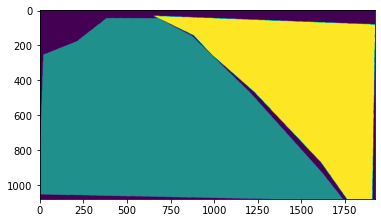

In [58]:
is_rotate_aug = True
def generator():    
    for i in range(0, (len(input_list_train)//2)*2):
        x = input_list_train[i//2]        
        y_seg = seg_list_train[i//2]
        
        if False and (strategy.num_replicas_in_sync%2==0 and i%2==1):            
            x = x[:, ::-1]
            y_seg = y_seg[:, ::-1]            
      
        if is_rotate_aug:            
            angle = 5 * (np.random.rand() - 0.5) #0~1 > -0.5~0.5
            if np.abs(angle) > 0.1:                
                x_rotated = Image.fromarray(x).rotate(angle)
                y_seg_rotated = Image.fromarray(y_seg).rotate(angle, Image.NEAREST)
                x = np.array(x_rotated)
                y_seg = np.array(y_seg_rotated)

        yield (x, y_seg)

def generator_test():    
    for i in range(len(input_list_test)):
        x = input_list_test[i]        
        y_seg = np.zeros_like(x[:, :, 0], np.uint8)
        
        yield (x, y_seg)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.uint8), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, None]))
)
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.uint8), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, None]))
)

np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    seg = example[1]
        
    print(image.dtype, image.shape, seg.shape)
    plt.imshow(seg)
    break

In [79]:
batch_size = 2# * 4 #finetune 1 or 4
autotune = tf.data.experimental.AUTOTUNE

In [80]:
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
#train_dataset = train_dataset.shuffle(8 * batch_size)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
train_dataset = train_dataset.padded_batch(batch_size=batch_size)
train_dataset = train_dataset.map(label_encoder.encode_batch_train, num_parallel_calls=autotune)
train_dataset = train_dataset.prefetch(autotune)

#output_map (2, 1024, 1920, 3) (2, 1024, 1920, 1) (2, 60480, 9)

In [81]:
val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
#val_dataset = val_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
val_dataset = val_dataset.padded_batch(batch_size=batch_size)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [65]:
def load_weight():   
    weights_dir = path_weight#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir,by_name=False, skip_mismatch=False)

In [66]:
num_classes, num_classes_real, len(class_names), seg_k

(30, 5, 5, 15)

In [67]:
num_classes, anchor_k, seg_k, use_pedestrian

(30, 6, 15, False)

In [148]:
#optimizer = tf.optimizers.SGD(learning_rate=1e-5, momentum=0.1, clipvalue=5.)#warm up clipvalue=10. !

with strategy.scope():
    optimizer = tf.optimizers.SGD(learning_rate=1e-2, momentum=0.05)
    loss_seg = SegmentLoss(seg_k)
    model = createRetinaNet()

    model.compile(optimizer=optimizer, loss=loss_seg, metrics=seg_acc)
    callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=path_weight,
            monitor="loss",
            save_best_only=False,
            save_weights_only=True,
            verbose=0,
            save_freq=200
        )
    ]

In [149]:
model.summary()#4:8,682,381, 2:5,094,587

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
functional_29 (Functional)      [(None, None, None,  3132101     input_11[0][0]                   
__________________________________________________________________________________________________
a55 (Conv2D)                    (None, None, None, 2 53504       functional_29[0][3]              
__________________________________________________________________________________________________
a44 (Conv2D)                    (None, None, None, 2 30976       functional_29[0][2]              
______________________________________________________________________________________

In [150]:
with strategy.scope():
    load_weight()

latest_checkpoint weight/pedestrian_efficientSeg-2


In [151]:
print(len(input_list_train), len(input_list_test))#990 2857, 1170 3128

3313 1656


In [152]:
out = model.evaluate(val_dataset.take(10))

10/10 [==============================] - 1s 89ms/step - loss: 1.7649e-05 - seg_acc: 0.0000e+00


In [153]:
is_rotate_aug = True
epochs = 10000

hist = model.fit(train_dataset, epochs=epochs, callbacks=callbacks_list, verbose=1)
'''
s2 20s 457ms/step - loss: 0.0488 - seg_acc: 0.9664
   21s 477ms/step - loss: 0.0118 - seg_acc: 0.8103
  839s 507ms/step - loss: 0.1546 - seg_acc: 0.9101
'''

Epoch 1/10000
1656/1656 [==============================] - 832s 503ms/step - loss: 0.3544 - seg_acc: 0.8748
Epoch 2/10000
1656/1656 [==============================] - 836s 505ms/step - loss: 0.2769 - seg_acc: 0.8807
Epoch 3/10000
1656/1656 [==============================] - 837s 505ms/step - loss: 0.2448 - seg_acc: 0.8849
Epoch 4/10000
1656/1656 [==============================] - 837s 506ms/step - loss: 0.2335 - seg_acc: 0.8873
Epoch 5/10000
1656/1656 [==============================] - 837s 505ms/step - loss: 0.2202 - seg_acc: 0.8938
Epoch 6/10000
1656/1656 [==============================] - 837s 505ms/step - loss: 0.2013 - seg_acc: 0.8965
Epoch 7/10000
1656/1656 [==============================] - 837s 505ms/step - loss: 0.1809 - seg_acc: 0.9014
Epoch 8/10000
1656/1656 [==============================] - 838s 506ms/step - loss: 0.1901 - seg_acc: 0.8985
Epoch 9/10000
1656/1656 [==============================] - 838s 506ms/step - loss: 0.1739 - seg_acc: 0.9044
Epoch 10/10000
1656/1656 [==

KeyboardInterrupt: 

In [154]:
model.save_weights(path_weight)
path_weight

'weight/pedestrian_efficientSeg-2'

In [155]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
segment_h = model(image, training=False)
segment_cls = tf.argmax(segment_h, -1)

inference_model = tf.keras.Model(inputs=image, outputs=segment_cls)

In [156]:
is_rotate_aug = False

In [157]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes, max_crop=200)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=2
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        
        if cls == 3:
            color = [1, 0, 0]
        elif cls == 1:
            color = [1, 1, 1]
        else:
            color = [0, 0, 1]
            
        color_text = color#edgecolors[cls]
        
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            score_txt = str.format('(%d)%.2f' %(cls, score))
        else:
            score_txt = str.format('%d' %(cls))
        ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [162]:
def check_test(test_datas, step=1, is_rgb_show=True):
    i = 0
    for image, segmap in test_datas: 
        
        if i%step==0:                        
            
            scale = np.array(image.shape[:2])[::-1]
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
                       
            input_image, _, ratio = resize_and_pad_image(image, jitter=None)
            input_image = tf.expand_dims(input_image, axis=0)
            model_out = inference_model.predict(input_image)
            seg_h = (model_out[0]).astype(np.uint8)      
                        
            print(input_image.shape, seg_h.shape, np.mean(seg_h))
            
            if not is_rgb_show:
                img_seg_resized = Image.fromarray(seg_h).resize(segmap.shape[1::-1])
                arr_seg_resized = np.array(img_seg_resized)
                acc = np.mean(np.equal(segmap[:, :-100], arr_seg_resized[:, :-100]).astype(np.float))
                print('acc', acc)
                segmap_compare = np.concatenate((segmap, arr_seg_resized), axis=1)
                plt.figure(figsize=(20, 10))
                plt.imshow(segmap_compare)
                plt.show()
            else:
                visualize_detections(
                    image,
                    box,
                    cls_h,
                    scores,
                    boxes_gt=gt_bbox
                )
        i+=1

(1, 1024, 1920, 3) (1024, 1920) 1.539448038736979
acc 0.8646911884411884


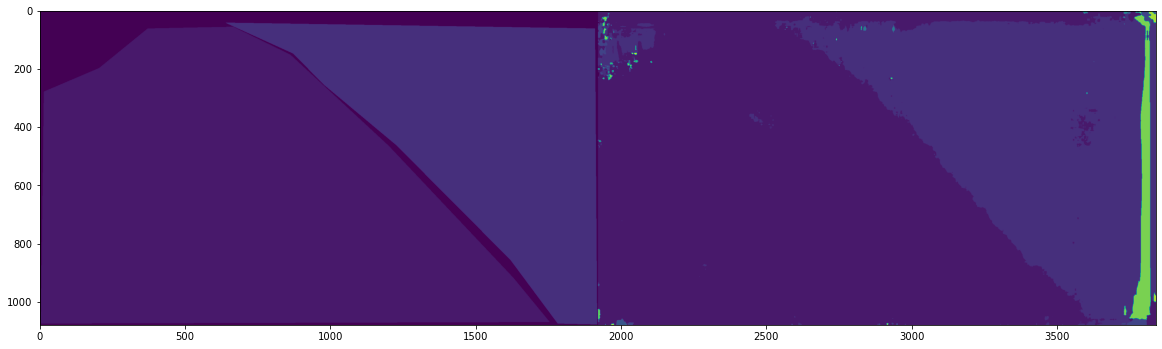

(1, 1024, 1920, 3) (1024, 1920) 11.966238911946615
acc 0.7284969397363465


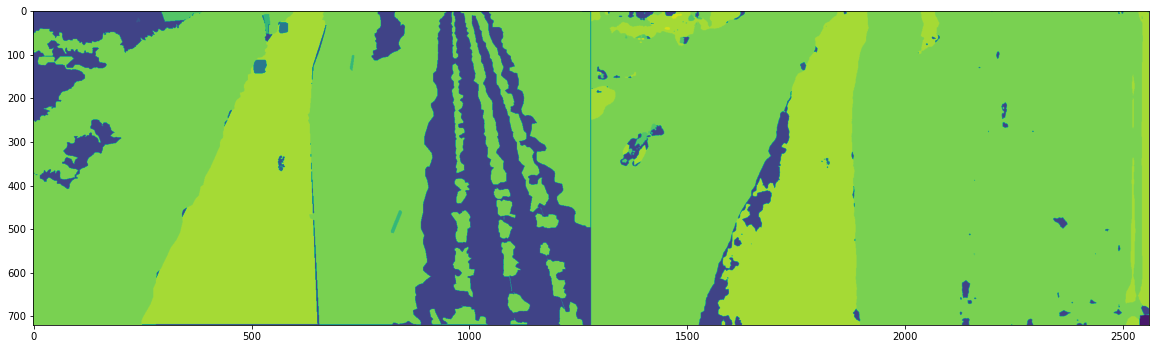

(1, 1024, 1920, 3) (1024, 1920) 7.064832560221354
acc 0.344191384180791


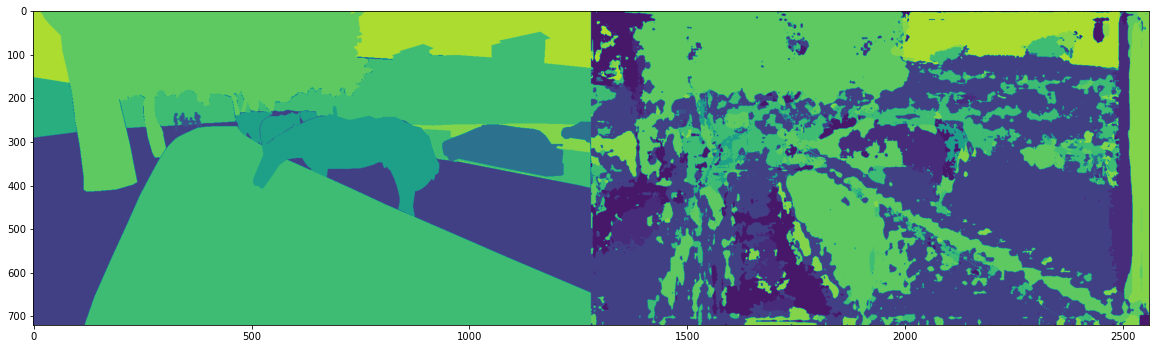

(1, 1024, 1920, 3) (1024, 1920) 11.636506144205729
acc 0.8018620527306968


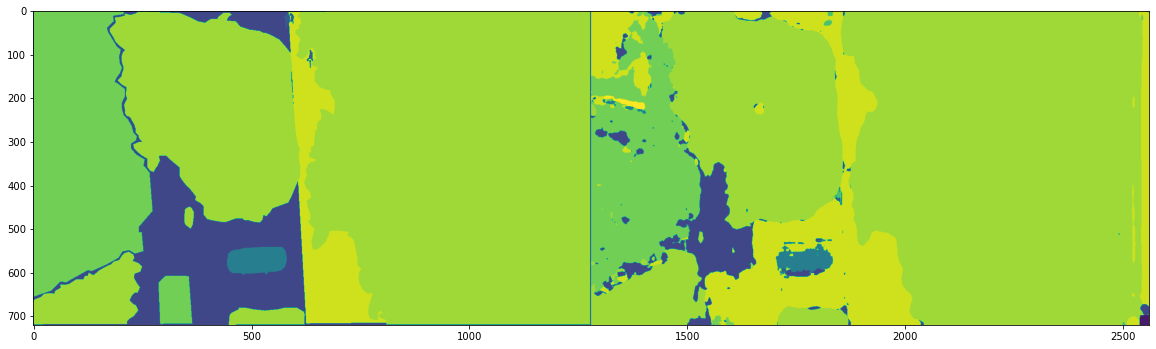

In [164]:
check_test(dataset, step=1000, is_rgb_show=False)

In [ ]:
check_test(dataset, step=10, is_rgb_show=False)

In [ ]:
check_test(dataset, step=1)

In [ ]:
def check_wrong(X, Y, annot):
    i=0
    for ann in annot:
        image, y = X[i], Y[i]
        #print('ann', ann)            
        i+=1
        
        scale = np.array(image.shape[:2])[::-1]
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = y[ :, :4] * scale
        #gt_bbox = y[:, 1:1+4]
        input_image, _, ratio = resize_and_pad_image(image, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)
        #input_image = tf.cast(input_image, tf.uint8)
        detected_box = inference_model.predict(input_image)
        if len(detected_box)>len(y):
            print('ann', ann)
            print('detected_box', detected_box.shape, 'gt', len(y))
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio

            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )

In [ ]:
check_wrong(input_list, bbox_list, annotation)

In [ ]:
def add_pad_32x_arr(image_arr):
    #print('image_arr', image_arr.shape, image_arr.dtype)
    stride = 32
    img_h = image_arr.shape[0]
    img_w = image_arr.shape[1]
    img_c = image_arr.shape[2]
    #print('add_pad_32x', image_arr.shape, img_h, img_w)
    pad_h = (stride - (img_h % stride)) % stride
    pad_w = (stride - (img_w % stride)) % stride
    padded_h = img_h + pad_h
    padded_w = img_w + pad_w
    #print('pad_h', pad_h, 'pad_w', pad_w)
    image_padded = np.zeros((padded_h, padded_w, img_c), dtype=np.uint8)
    image_padded[:img_h, :img_w] = image_arr
        
    return image_padded

In [ ]:
def check_testset(image, step=1, is_rgb_show=True):
 
    input_image, _, ratio = resize_and_pad_image(image, jitter=None)
    input_image = tf.expand_dims(input_image, axis=0)
    #input_image = tf.cast(input_image, tf.uint8)
    model_out = inference_model.predict(input_image)
    print('detected_box', type(model_out))
    detected_box = model_out[0]            
    seg_h = (model_out[1][0]).astype(np.uint8)      
    
    #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
    cls_h = detected_box[:, 0].astype(np.int)
    scores = detected_box[:, 1]
    box = detected_box[:, 2:] / ratio

    plt.imshow(seg_h)
    plt.show()


In [ ]:
test_folder  = '/home/mvlab/Downloads/dataset/사천 test/bg/'
os.path.isdir(test_folder)

In [ ]:
list_jpg = glob(test_folder + '*')
print(len(list_jpg))

In [ ]:
wrong = 0
for i in range(0, len(list_jpg)//100):    
    jpg = list_jpg[i]
    #print('i', i, jpg.split(os.sep)[-1])
    img = Image.open(jpg)
    arr = np.array(img)
    print(jpg, arr.shape)
    
    check_testset(arr)

## video inference, save result
1. split image from video
1. get target image paths
1. inference, save result to list
1. save as csv format

In [ ]:
import cv2
import time
def video_to_frames(input_loc, stride=1):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
        
    folder_split = input_loc.split(os.sep)
    file_name = folder_split[-1]
    file_name = file_name.split('.')[0]
    output_loc = os.sep.join(folder_split[:-1]) + os.sep + file_name + os.sep    
    print('output_loc', output_loc)
        
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    save_count = 0
    print ("Converting video..\n")
    # Start converting the video
    
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        count = count + 1        
        file_name = "%#05d.jpg" % (count+1)        
        dst_name = output_loc + file_name
        
        try:
            cv2.imwrite(dst_name, frame)
            #b, g, r = np.split(frame, 3, -1)
            #rgb = np.concatenate((r,g,b), -1)        
            save_count += 1
        except:
            print('except', cap, ret, frame, dst_name)
            break
        
        # If there are no more frames left
        if count%100==0:
            print('count', video_length, count, save_count)
       
    time_end = time.time()
    # Release the feed
    cap.release()
    # Print stats
    print ("Done extracting frames.\n%d frames extracted" % count)
    print ("It took %d seconds to save %d for conversion ." % (time_end-time_start, save_count))
    return output_loc

In [ ]:
path_avi = '/home/mvlab/Videos/미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]140000-[20201217]141000(20201217_140001).avi'
os.path.isfile(path_avi)

In [ ]:
output_loc = video_to_frames(path_avi)

In [ ]:
#                                미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]135000-[20201217]140000(20201217_135001)
output_loc = '/home/mvlab/Videos/미수방향1_2/'
os.path.isdir(output_loc)

In [ ]:
#paths_test_img = glob('/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/*미수방향1*/*.jpg')
paths_test_img = glob(output_loc + '*')
print(len(paths_test_img), output_loc)
paths_test_img = np.sort(paths_test_img)

In [ ]:
def convert_label_list_to_df(list_output):
    print('convert_label_list_to_df')
    df = pd.DataFrame(columns=['path', 'cls', 'x0', 'y0', 'x1', 'y1', 'confidence'])
    
    ratio = 0.9481481481481482
    for output in list_output:
        path_img = output[0]
        detected_box = output[1]

        for box in detected_box:
            cls_h = box[0].astype(np.int)
            scores = (box[1]*100).astype(np.int)
            box_coord = box[2:2+6]/ratio
            x0 = box_coord[0].astype(np.int)
            y0 = box_coord[1].astype(np.int)
            x1 = box_coord[2].astype(np.int)
            y1 = box_coord[3].astype(np.int)
            row = {'path':path_img, 'cls':cls_h, 'x0':x0, 'y0':y0, 'x1':x1, 'y1':y1, 'confidence':scores}
            df = df.append(row, ignore_index=True)
            
    return df

def save_inference_result(paths_img):
    
    print('len', len(paths_img))
    
    list_output = []
    for i in range(len(paths_img)):
        path_img = paths_img[i]
        if i % 100 == 0:
            print(len(paths_img), i, path_img.split(os.sep)[-1])
        
        img = Image.open(path_img)
        img_arr = np.array(img)
        input_image, _, ratio = resize_and_pad_image(img_arr, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)        
        detected_box = inference_model.predict(input_image)
        
        if len(detected_box) > 0:            
            list_output.append([path_img, detected_box])
        
        if len(list_output) > 0 and len(list_output)%1000==0:
            df = convert_label_list_to_df(list_output)            
            df.to_csv('predict_temp.csv')
    
    df = convert_label_list_to_df(list_output)            
    df.to_csv('predict.csv')
    print('finished')


In [ ]:
save_inference_result(paths_test_img[:])

In [ ]:
seg_k

## Freeze Model

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [ ]:
 # Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: inference_model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(inference_model.inputs[0].shape, inference_model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]


In [ ]:
print('inputs', type(frozen_func.inputs), len(frozen_func.inputs), frozen_func.inputs)
print('outputs', type(frozen_func.outputs), len(frozen_func.outputs), frozen_func.outputs)

In [ ]:
path_weight

In [ ]:
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="Sacheon_efficientSeg-2_frozen_graph.pb",
                  as_text=False)

In [ ]:
def check_error(X, Y, Path, step=1):
    
    for i in range(len(X)): 
        image = X[i]
        bbox_annotation = Y[i]
        path = Path[i]
        
        scale = np.array(image.shape[:2])[::-1]
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = bbox_annotation[:, 1:] * scale

        input_image, _, ratio = resize_and_pad_image(image, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)

        detected_box = inference_model.predict(input_image)
        detect_k = len(detected_box)
        if detect_k!= len(bbox_annotation):
            print(path, input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio.numpy())
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)

            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        

In [ ]:
start = 1000
end = start + 100
check_error(input_list[start:end], bbox_list[start:end], path_list[start:end])

## load model from .pb file

In [ ]:
saved_model_pb = './Sacheon_efficientSeg-2'

In [ ]:
inference_model.save(saved_model_pb)

In [ ]:
custom_objects = {'recall':recall,'precision':precision}
model_loaded = keras.models.load_model(saved_model_pb, custom_objects=custom_objects, compile=False)
#model_loaded.summary()

In [ ]:
model_loaded.compile()

In [ ]:
for image, cbbox in val_dataset: 
    
    detected_box = model_loaded.predict(image)
    print('detected_box', detected_box.shape)
    if len(detected_box) > 0:
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]

        visualize_detections(
            image[0],
            box,
            cls_h,
            scores
        )    
    break

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_pb)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter

In [ ]:
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls *.tflite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_details, output_details

In [ ]:
input_data = input_list_train[0]
input_data = (np.expand_dims(input_data, 0)/255).astype(np.float32)
input_data.shape

In [ ]:
input_data = input_data[:, :padded_image_shape[0], :padded_image_shape[1]]
input_data.shape, np.max(input_data)

In [ ]:
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print('input_data', input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
tflite_results.shape

In [ ]:
tflite_results[0]

In [ ]:
detected_box = tflite_results
cls_h = detected_box[:, 0].astype(np.int)
scores = detected_box[:, 1]
box = detected_box[:, 2:] / ratio
#print('box', box)

visualize_detections(
    input_data[0]*255,
    box,
    cls_h,
    scores,
)